MaxCut on an undirected graph $G = \{V, E\}$ with $n = 5$ vertices $V = \{0, 1, 2, 3, 4\}$ and 6 edges $E = \{(0,1), (0,2), (1,2), (3,2), (3,4), (4,2)\}$ with unit weight $w_{i, j} = 1$.
The MaxCut classical objective function is as follows
$$
L(z) = \sum_{\{i, j\} \in E} w_{i, j}z_i(1 - z_j) + w_{i, j} z_j(1 - z_i),
$$
with $z_i \in \{-1, 1\}$ for $i \in V$.

The equivalent problem Hamiltonian can be described in terms of $Z$ interactions:
$$
H_L = \frac{1}{2} \sum_{\{i, j\} \in E} w_{i, j}(I - Z^{(i)}Z^{(j)}),
$$
where $Z^{(i)}$ is the Pauli-Z operator acting on qubit $i$.

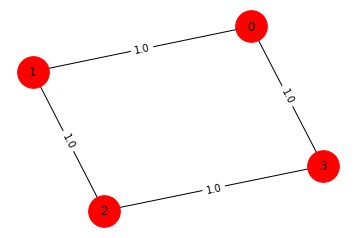

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

n = 4
V = np.arange(0, n, 1)
E =[(0, 1, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

edge_labels = nx.get_edge_attributes(G, 'weight')
default_axes = plt.axes(frameon=False, xticks=[], yticks=[])
pos = nx.spring_layout(G)

nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
nx.draw_networkx(G, node_size=1000, alpha=1, ax=default_axes, pos=pos)

In [49]:
def L(G, z):
    cost = 0
    
    for i, j in G.edges:
        w = G[i][j]['weight']
        cost += w*z[i]*(1 - z[j]) + w*z[j]*(1 - z[i])
    
    return cost

In [50]:
import itertools

zs = list(itertools.product([0, 1], repeat=4))
for z in zs:
    print(f'L({z}) = {L(G, z)}')

L((0, 0, 0, 0)) = 0.0
L((0, 0, 0, 1)) = 2.0
L((0, 0, 1, 0)) = 2.0
L((0, 0, 1, 1)) = 2.0
L((0, 1, 0, 0)) = 2.0
L((0, 1, 0, 1)) = 4.0
L((0, 1, 1, 0)) = 2.0
L((0, 1, 1, 1)) = 2.0
L((1, 0, 0, 0)) = 2.0
L((1, 0, 0, 1)) = 2.0
L((1, 0, 1, 0)) = 4.0
L((1, 0, 1, 1)) = 2.0
L((1, 1, 0, 0)) = 2.0
L((1, 1, 0, 1)) = 2.0
L((1, 1, 1, 0)) = 2.0
L((1, 1, 1, 1)) = 0.0


Optimal solutions are $z = 1010$ and $z = 0101$ with $L(z) =  4$.

In [74]:
from projectq import MainEngine
from projectq.backends import ResourceCounter, Simulator
from projectq.ops import All, H, Rz, Rx, CNOT, Measure, QubitOperator
from projectq.setups import restrictedgateset
from quantuminspire.projectq.backend_qx import QIBackend

class QAOA:
    def __init__(self, G, n, gamma, beta, p=1, eng_kwargs={}, use_qi=False, qi_backend_kwargs=None):
        self.use_qi = use_qi
        self.eng_kwargs = eng_kwargs
        self.qi_backend_kwargs = qi_backend_kwargs
        self._renew_engine()
            
        self.G = G
        self.gamma = gamma
        self.beta = beta
        self.p = p
        
    def _renew_engine(self):
        if self.use_qi:
            if self.qi_backend_kwargs is None:
                raise RuntimeError("qi_backend_kwargs is required when use_qi=True")
            qi_backend = QIBackend(**self.qi_backend_kwargs)
            
            compiler_engines = restrictedgateset.get_engine_list(
                one_qubit_gates=qi_backend.one_qubit_gates,
                two_qubit_gates=qi_backend.two_qubit_gates,
                other_gates=qi_backend.three_qubit_gates
            )
            compiler_engines.extend([ResourceCounter()])
            
            self.eng_kwargs["backend"] = qi_backend
            self.eng_kwargs["engine_list"] = compiler_engines

        self.eng = MainEngine(**self.eng_kwargs)  
        self.q = self.eng.allocate_qureg(n)
        
    def qaoa_circuit(self):
        All(H) | self.q

        for i in range(self.p):
            # problem unitary
            for k, l in self.G.edges:
                CNOT | (self.q[k], self.q[l])
                Rz(-self.gamma[i]) | self.q[l]
                CNOT | (self.q[k], self.q[l])

            # mixer unitary
            All(Rx(2*self.beta[i])) | self.q
    
    @staticmethod
    def _even_ones(binary, relevant_idxs):
        integer = int(binary)
        ones_rel_idxs = 0
        for i in relevant_idxs:
            ones_rel_idxs += 10**i
        
        n_ones = str(integer + ones_rel_idxs).count('2')
        
        return n_ones % 2 == 0
    
    def probabilities(self, shots=1024):
        if self.use_qi:
            # Quantum Inspire back-end does 1024 shots by default and
            #   saves probabilities in the back-end object
            self.qaoa_circuit()
            All(Measure) | self.q

            self.eng.flush()
            results = self.eng.backend.get_probabilities(self.q)
            self._renew_engine()

            return results
        else:
            # sample results manually through repeated shots
            results = {}
            for _ in range(shots): 
                self.qaoa_circuit()
                All(Measure) | self.q

                result = ''.join(str(int(q)) for q in reversed(self.q))
                results[result] = results.get(result, 0) + 1

                self.eng.flush()

            for result, count in results.items():
                results[result] = count/shots

            return results
    
    def expval(self, operator, shots=1024):
        expval = 0
        
        for term, coef in operator.terms.items():
            rotations = []
            qubits_of_interest = []
            
            # if term is identity, add constant coefficient
            if term == (): 
                expval += coef
                continue
            
            for qubit, op in term:     
                qubits_of_interest.append(qubit)
                
                if op == 'X':
                    rotations.append((Ry(-np.pi/2), qubit))
                elif op == 'Y':
                    rotations.append((Rx(np.pi/2), qubit))
            
            results = None
            if self.use_qi:
                # Quantum Inspire back-end does 1024 shots by default and
                #   saves probabilities in the back-end object
                self.qaoa_circuit()

                for rot, i in reversed(rotations):
                    rot | self.q[i]

                All(Measure) | self.q

                self.eng.flush()
                results = self.eng.backend.get_probabilities(self.q)
                # can only use engine once with QI back-end
                self._renew_engine() 
            else:
                # sample results manually through repeated shots
                results = {}
                for _ in range(shots): 
                    self.qaoa_circuit()

                    for rot, i in reversed(rotations):
                        rot | self.q[i]

                    All(Measure) | self.q
                    
                    self.eng.flush()

                    result = ''.join(str(int(q)) for q in reversed(self.q))
                    results[result] = results.get(result, 0) + 1
                
                for result, count in results.items():
                    results[result] = count/shots
                
            for result, count in results.items():
                if self._even_ones(result, qubits_of_interest):
                    parity = 1
                else:
                    parity = -1

                expval += parity * coef * count
        
        return expval

In [69]:
def cost(qaoa):
    cost = 0
    cost_hamiltonian = 0 * QubitOperator('')
    for i, j in G.edges:
        w = G[i][j]['weight']
        cost_hamiltonian += 0.5 * w * (QubitOperator('') - QubitOperator(f"Z{i} Z{j}"))
    
    cost -= qaoa.expval(cost_hamiltonian)
        
    return cost

In [73]:
from quantuminspire.credentials import enable_account, get_token_authentication
from quantuminspire.api import QuantumInspireAPI
  
enable_account('6ea0bc8530ed4c97073aff535b5b52fd617cc6ed')
auth = get_token_authentication()
server_url = r'https://api.quantum-inspire.com'
qi = QuantumInspireAPI(server_url, auth, project_name='qaoa_maxcut')

gamma, beta = [1.2], [1.2]
qaoa = QAOA(G, n, gamma, beta,
            use_qi=True,
            qi_backend_kwargs={"quantum_inspire_api": qi, "backend_type": "QX single-node simulator"})
cost(qaoa)

Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.
Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.


-1.294921875